In [ ]:
import zipfile
with zipfile.ZipFile('home-credit-default-risk (1).zip', 'r') as zip_ref:
    zip_ref.extractall('home-credit-default-risk')

### For model 1, we are going to only use the data from the application dataset. 

In [1]:
import pandas as pd
import numpy as np
application_train = pd.read_csv("home-credit-default-risk/application_train.csv")
application_test = pd.read_csv("home-credit-default-risk/application_test.csv")

In [2]:
y_train = application_train['TARGET']
application_train = application_train.drop(['TARGET'], axis = 1)

### Fill in the nans, standardize numeric data and apply onehot encoding to categorical data

In [3]:
types = application_train.dtypes

In [4]:
cols = application_train.columns

In [5]:
cols = cols[1:]

In [6]:
types[cols[1]] == 'object'

True

In [7]:
categorical_application = []

In [8]:
numerical_application = []

In [9]:
uniques = application_train.nunique()

In [10]:
for column in cols:
    if types[column] == 'object':
        categorical_application.append(column)
    else:
        if uniques[column] < 15:
            categorical_application.append(column)
        else:
            numerical_application.append(column)

In [11]:
X =  pd.concat([application_train, application_test], keys = [0,1])

In [12]:
missing_per_col = {}
cols = X.columns
for col in cols:
    missing_per_col[col] = X[col].isnull().sum()/len(X)

In [13]:
not_miss = X.columns[X.isnull().mean() < 0.5]

In [14]:
for col in categorical_application:
    X[col] = X[col].fillna(X[col].mode()[0])

for col in numerical_application:
    X[col] = X[col].fillna(X[col].median())

In [15]:
X = X[not_miss]
numeric_application = list(set(not_miss) & set(numerical_application))
categorical_application = list(set(not_miss) & set(categorical_application))

In [16]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X[numeric_application] = scaler.fit_transform(X[numeric_application])

In [17]:
X = pd.get_dummies(X, columns = categorical_application)

In [18]:
train = X.xs(0)
test = X.xs(1)

In [19]:
train_id_curr = train['SK_ID_CURR']
test_id_curr = test['SK_ID_CURR']

In [20]:
train = train.drop(['SK_ID_CURR'], axis = 1)
test = test.drop(['SK_ID_CURR'], axis = 1)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [21]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(alpha=0.1, penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
clf.fit(train, y_train)

SGDClassifier(alpha=0.1, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [22]:
preds = clf.predict_proba(test)[:,1]

In [23]:
from sklearn.metrics import roc_auc_score
sub1 = pd.read_csv('sample_submission (1).csv')
sub1['TARGET'] = preds
sub1.to_csv('submission1.csv', index = None)

### The model uses SGDClassifier with log loss and L1 penalty

In [28]:
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(SGDClassifier(alpha=0.1, penalty='l1',class_weight = 'balanced', loss='log', random_state=28), train, y_train, cv=5)))

0.6715402127187118


### For  Model 2 we are going to tune the C parameter using cross validation and gridsearch

In [29]:
alphas = np.logspace(-4,4,9)
params_grid = {'alpha': alphas}
from sklearn.model_selection import GridSearchCV
clf_gridsearchcv = GridSearchCV(estimator = SGDClassifier(penalty='l1',class_weight = 'balanced', loss='log', random_state=28), param_grid=params_grid, cv = 5, scoring = 'roc_auc', verbose=10, n_jobs = 4)
clf_gridsearchcv.fit(train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   23.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   43.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   55.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed:  1.4min remaining:    4.0s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5, random_state=28,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             pre_dispatch='2*n_jobs', refit=True, 

In [30]:
('Best score: ', clf_gridsearchcv.best_score_)

('Best score: ', 0.7369829872068332)

In [31]:
print('Best estimator: ', clf_gridsearchcv.best_estimator_)

Best estimator:  SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [32]:
model2 = SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [33]:
model2.fit(train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [34]:
preds = model2.predict_proba(test)[:,1]

In [35]:
from sklearn.metrics import roc_auc_score
sub2 = pd.read_csv('sample_submission (1).csv')
sub2['TARGET'] = preds
sub2.to_csv('submission2.csv', index = None)

### For  Model 3 we are going to fit Randomforest to find the most important features

In [36]:
from sklearn.ensemble import RandomForestClassifier
importance_gen = RandomForestClassifier()
importance_gen.fit(train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
importances = importance_gen.feature_importances_

In [38]:
importances

array([8.74778916e-03, 2.94149259e-02, 3.23685069e-02, 3.41355756e-02,
       2.84814851e-02, 2.82214530e-02, 3.78020664e-02, 3.28533736e-02,
       3.68748739e-02, 3.77985343e-02, 1.17890953e-02, 2.58076573e-02,
       5.42458700e-02, 5.12701439e-02, 1.48406112e-02, 6.76144309e-03,
       1.66754123e-02, 1.47749428e-02, 6.07943894e-03, 1.67612367e-02,
       1.45587274e-02, 6.39069032e-03, 1.66795925e-02, 1.72186850e-02,
       1.49428677e-02, 1.47845211e-02, 3.34131860e-02, 6.06376438e-03,
       1.87844715e-02, 4.16726107e-03, 3.26600196e-03, 2.50100531e-03,
       6.54023678e-04, 4.07405121e-04, 6.69588954e-05, 6.17252113e-05,
       8.28825906e-06, 0.00000000e+00, 1.00220597e-05, 0.00000000e+00,
       1.99690409e-04, 2.20502193e-04, 6.54422424e-05, 6.58716419e-05,
       1.13352061e-03, 4.22471015e-03, 2.18803394e-04, 5.25959330e-04,
       9.80236362e-04, 2.15324150e-03, 4.85606109e-03, 1.57045820e-03,
       1.50424223e-03, 1.67582093e-03, 1.68554253e-03, 2.09759507e-05,
      

In [39]:
feats_ordered = train.columns[np.argsort(importances)[::-1]]

In [40]:
# Now, we will take the first 100 most important features

In [41]:
feats_ordered

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'DAYS_REGISTRATION', 'AMT_ANNUITY', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_EMPLOYED', 'AMT_CREDIT', 'AMT_INCOME_TOTAL',
       ...
       'NAME_FAMILY_STATUS_Unknown', 'REGION_RATING_CLIENT_W_CITY_-1',
       'AMT_REQ_CREDIT_BUREAU_QRT_8.0', 'AMT_REQ_CREDIT_BUREAU_WEEK_7.0',
       'AMT_REQ_CREDIT_BUREAU_HOUR_4.0', 'FLAG_MOBIL_0', 'FLAG_MOBIL_1',
       'NAME_INCOME_TYPE_Businessman', 'CODE_GENDER_XNA',
       'AMT_REQ_CREDIT_BUREAU_QRT_261.0'],
      dtype='object', length=282)

In [42]:
train_1 = train[feats_ordered[0:200]]
alphas = np.logspace(-4,4,9)
params_grid = {'alpha': alphas}
from sklearn.model_selection import GridSearchCV
clf_gridsearchcv = GridSearchCV(estimator = SGDClassifier(penalty='l1',class_weight = 'balanced', loss='log', random_state=28), param_grid=params_grid, cv = 5, scoring = 'roc_auc', verbose=10, n_jobs = 4)
clf_gridsearchcv.fit(train_1, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   23.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   42.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   57.9s
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed:  1.1min remaining:    3.1s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5, random_state=28,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             pre_dispatch='2*n_jobs', refit=True, 

In [43]:
('Best score: ', clf_gridsearchcv.best_score_)

('Best score: ', 0.7366383058967435)

In [44]:
print('Best estimator: ', clf_gridsearchcv.best_estimator_)

Best estimator:  SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [45]:
test_1 = test[feats_ordered[0:200]]

In [46]:
model3 = SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)
model3.fit(train_1, y_train)
preds = model3.predict_proba(test_1)[:,1]

In [47]:
preds = model3.predict_proba(test_1)[:,1]

In [48]:
from sklearn.metrics import roc_auc_score
sub3 = pd.read_csv('sample_submission (1).csv')
sub3['TARGET'] = preds
sub3.to_csv('submission3.csv', index = None)

# Model 4

# Let's now try to use WOE to encode categorical features

In [49]:
X = pd.concat([application_train, application_test], keys = [0,1])

In [50]:
for col in categorical_application:
    X[col] = X[col].fillna(X[col].mode()[0])

for col in numerical_application:
    X[col] = X[col].fillna(X[col].median())

In [51]:
X = X[not_miss]
numeric_application = list(set(not_miss) & set(numerical_application))
categorical_application = list(set(not_miss) & set(categorical_application))

In [52]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X[numeric_application] = scaler.fit_transform(X[numeric_application])

In [53]:
train = X.xs(0)
test = X.xs(1)

In [54]:
train = train.drop(['SK_ID_CURR'], axis = 1)
test = test.drop(['SK_ID_CURR'], axis = 1)

In [55]:
import category_encoders as ce

In [56]:
woe_encoder = ce.WOEEncoder(cols=categorical_application)
train = woe_encoder.fit_transform(train, y_train).add_suffix('_woe')

In [57]:
test = woe_encoder.transform(test).add_suffix('_woe')

In [58]:
clf_gridsearchcv = GridSearchCV(estimator = SGDClassifier(penalty='l1',class_weight = 'balanced', loss='log', random_state=28), param_grid=params_grid, cv = 5, scoring = 'roc_auc', verbose=10, n_jobs = 4)
clf_gridsearchcv.fit(train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   13.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   28.1s
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed:   32.4s remaining:    1.5s
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   33.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', power_t=0.5, random_state=28,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
             pre_dispatch='2*n_jobs', refit=True, 

In [59]:
('Best score: ', clf_gridsearchcv.best_score_)

('Best score: ', 0.739694988893162)

In [60]:
print('Best estimator: ', clf_gridsearchcv.best_estimator_)

Best estimator:  SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [61]:
model4 = SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=28, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)
model4.fit(train, y_train)
preds = model4.predict_proba(test)[:,1]

In [62]:
from sklearn.metrics import roc_auc_score
sub4 = pd.read_csv('sample_submission (1).csv')
sub4['TARGET'] = preds
sub4.to_csv('submission4.csv', index = None)

# Graph cross validation vs submission score

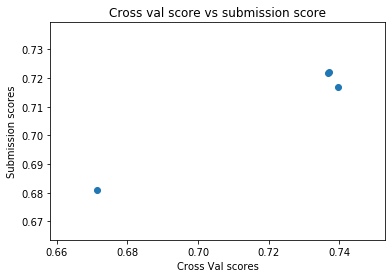

In [63]:
submits = [0.68086, 0.72216, 0.72167, 0.71678]
cross_vals = [0.6715402127187118, 0.7369829872068332, 0.7366383058967435, 0.739694988893162]
import matplotlib.pyplot as plt
plt.scatter(cross_vals, submits)
plt.title('Cross val score vs submission score')
plt.xlabel('Cross Val scores')
plt.ylabel('Submission scores')
plt.show()

# Лучшие результаты получила модель с one hot энкодингом и подобранным С гиперпараметром. 